In [6]:
# Pseudocode syntax desired:

# dataset_dependencies = {ds1: sweep_param1, meas_param1,…} #(or whatever the format is)
# with Complex_Measurements_Context(dataset_dependencies):
# 	# Under the hood this will
# 	## Create separate Measurement objects for each dataset
# 	## Register parameters
	
# 	for mag_field in mag_field_Linsweep-like:
# 		for device in devices_to_measure:
# 			setup_device(device)
#             dond-like(params[device])

# Imports

In [7]:
import time
from contextlib import ExitStack, contextmanager
from functools import partial
from itertools import chain, product
from typing import *

import matplotlib.pyplot as plt
import numpy as np

import qcodes as qc
from qcodes.dataset import LinSweep, Measurement, plot_dataset
from qcodes.dataset.dond.do_nd import _parse_dond_arguments, _Sweeper
from qcodes.dataset.dond.do_nd_utils import _catch_interrupts
from qcodes.dataset.threading import _call_params, process_params_meas
from qcodes.parameters import (
    DelegateParameter,
    ManualParameter,
    Parameter,
    ParameterBase,
    ParameterWithSetpoints,
)
from qcodes.validators import Arrays

# Complex Measurement Context

### Setting up Dummy Parameters for testing

In [8]:
set1 = Parameter("set1", get_cmd = None, set_cmd=None, initial_value=0)
set2 = Parameter("set2",  get_cmd = None, set_cmd=None, initial_value=0)
set3 = Parameter("set3",  get_cmd = None, set_cmd=None, initial_value=0)


def get_set1():
    return set1()


def get_sum23():
    return set2() + set3()


def get_diff23():
    return set2() - set3()


meas1 = Parameter("meas1", get_cmd=get_set1, set_cmd=False)
meas2 = Parameter("meas2", get_cmd=get_sum23, set_cmd=False)
meas3 = Parameter("meas3", get_cmd=get_diff23, set_cmd=False)

### Complex Measurement Context Definitions

In [9]:
def setup_measurement_instances(dataset_definition, experiment):
    measurements: List[Measurement] = []
    for dataset_name in dataset_definition.keys():
        meas = Measurement(name=dataset_name, exp = experiment)
        indep_params = dataset_definition[dataset_name]['independent']
        dep_params = dataset_definition[dataset_name]['dependent']
        for param in indep_params:
            # print(param.name, type(param), meas)
            meas.register_parameter(param)
        for param in dep_params:
            # print(param.name, type(param), meas)
            meas.register_parameter(param, setpoints = indep_params)
        measurements.append(meas)
    return measurements


@contextmanager
def complex_measurement_context(dataset_definition, experiment):
    measurement_instances = setup_measurement_instances(dataset_definition, experiment)
    with _catch_interrupts() as interrupted, ExitStack() as stack:
        datasavers = [stack.enter_context(measurement.run()) for measurement in measurement_instances]
        try:
            yield datasavers
        except Exception:
            raise Exception

### Testing the context

In [10]:
db_path = "complex.db"
qc.initialise_or_create_database_at(db_path)
experiment = qc.load_or_create_experiment("Test")

dataset_definition = {"dataset_1" : {"independent": [set1], "dependent": [meas1]},
                      "dataset_2" : {"independent": [set1, set2, set3], "dependent" : [meas2, meas3]}}
with complex_measurement_context(dataset_definition, experiment) as datasavers:
    for val in range(5):
        set1(val)
        meas1_val = meas1()
        datasavers[0].add_result((set1, val), (meas1, meas1_val))
        for val2, val3 in product(range(5), repeat=2):
            set2(val2)
            set3(val3)
            meas2_val = meas2()
            meas3_val = meas3()
            datasavers[1].add_result((set1, val), (set2, val2), (set3, val3), (meas2, meas2_val), (meas3, meas3_val))
    datasets =[datasaver.dataset for datasaver in datasavers]

Starting experimental run with id: 51. 
Starting experimental run with id: 52. 


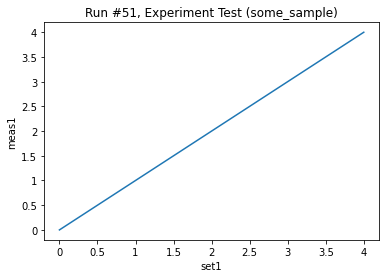

In [11]:
plot_dataset(datasets[0]);

In [12]:
xr_ds1 = datasets[1].to_xarray_dataset()
xr_ds1

<xarray.Dataset>
Dimensions:  (set1: 5, set2: 5, set3: 5)
Coordinates:
  * set1     (set1) float64 0.0 1.0 2.0 3.0 4.0
  * set2     (set2) float64 0.0 1.0 2.0 3.0 4.0
  * set3     (set3) float64 0.0 1.0 2.0 3.0 4.0
Data variables:
    meas2    (set1, set2, set3) float64 0.0 1.0 2.0 3.0 4.0 ... 5.0 6.0 7.0 8.0
    meas3    (set1, set2, set3) float64 0.0 -1.0 -2.0 -3.0 ... 3.0 2.0 1.0 0.0
Attributes: (12/14)
    ds_name:                  dataset_2
    sample_name:              some_sample
    exp_name:                 Test
    snapshot:                 {"station": {}}
    guid:                     aaaaaaaa-0000-0000-0000-0185a6a2074a
    run_timestamp:            2023-01-12 07:38:34
    ...                       ...
    captured_counter:         52
    run_id:                   52
    run_description:          {"version": 3, "interdependencies": {"paramspec...
    parent_dataset_links:     []
    run_timestamp_raw:        1673537914.7253466
    completed_timestamp_raw:  1673537914.7763722

# dond_core for Complex Measurement Context

In [13]:
def dond_core(datasaver, *params, additional_setpoints = tuple()):
    sweep_instances, params_meas = _parse_dond_arguments(*params)
    sweeper = _Sweeper(sweep_instances, additional_setpoints)
    for set_events in sweeper:
        results: dict[ParameterBase, Any] = {}
        additional_setpoints_data = process_params_meas(additional_setpoints)
        for set_event in set_events:
            if set_event.should_set:
                set_event.parameter(set_event.new_value)
                for act in set_event.actions:
                    act()
                time.sleep(set_event.delay)

            if set_event.get_after_set:
                results[set_event.parameter] = set_event.parameter()
            else:
                results[set_event.parameter] = set_event.new_value

        meas_value_pair =_call_params(tuple(params_meas))
        for meas_param, value in meas_value_pair:
            results[meas_param] = value

        filtered_results_list = [
            (param, value)
            for param, value in results.items()
        ]
        datasaver.add_result(
            *filtered_results_list,
            *additional_setpoints_data,
        )

## Testing dond_core with 1 datasaver

Starting experimental run with id: 53. 


([<AxesSubplot: title={'center': 'Run #53, Experiment Test (some_sample)'}, xlabel='set1', ylabel='meas1'>],
 [None])

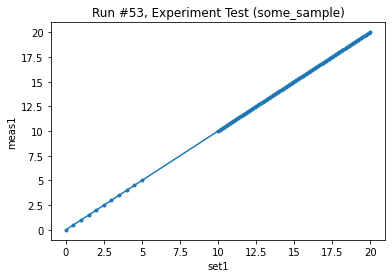

In [14]:
core_test_measurement = Measurement(name="core_test_1", exp=experiment)
core_test_measurement.register_parameter(set1)
core_test_measurement.register_parameter(meas1, setpoints=[set1])
with core_test_measurement.run() as datasaver:
    sweep1 = LinSweep(set1, 0, 5, 11, 0.001)
    dond_core(datasaver, sweep1, meas1)

    sweep2 = LinSweep(set1, 10, 20, 100, 0.001)
    dond_core(datasaver, sweep2, meas1)
    
    dataset = datasaver.dataset
plot_dataset(dataset, marker=".")

## Testing dond_core with complex context

Starting experimental run with id: 54. 
Starting experimental run with id: 55. 


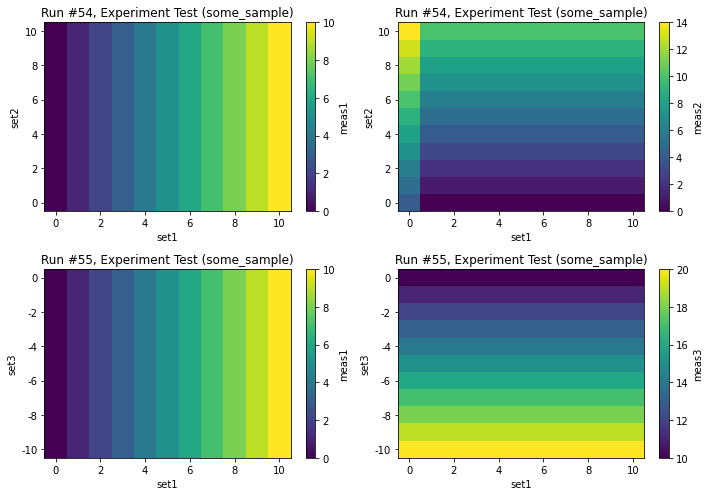

In [15]:
db_path = "complex.db"
qc.initialise_or_create_database_at(db_path)
experiment = qc.load_or_create_experiment("Test")

dataset_definition = {"dataset_1" : {"independent": [set1, set2], "dependent": [meas1, meas2]},
                      "dataset_2" : {"independent": [set1, set3], "dependent" : [meas1, meas3]}}
with complex_measurement_context(dataset_definition, experiment) as datasavers:
    for _ in LinSweeper(set1, 0, 10, 11, 0.001):
    # for val in range(11):
    #     set1(val)
    #     time.sleep(0.001)
        sweep1 = LinSweep(set2, 0, 10, 11, 0.001)
        sweep2 = LinSweep(set3, -10, 0, 11, 0.001)
        dond_core(datasavers[0], sweep1, meas1, meas2, additional_setpoints=(set1,))
        dond_core(datasavers[1], sweep2, meas1, meas3, additional_setpoints=(set1,))
    datasets =[datasaver.dataset for datasaver in datasavers]

fig, (ax, ax2) = plt.subplots(2,2, figsize = (10,7), tight_layout=True)
plot_dataset(datasets[0], axes=ax)
plot_dataset(datasets[1], axes=ax2);

## A more realistic example

### Setting up parameters, devices, and device setup function

In [16]:
magX: Parameter = Parameter("magX", get_cmd = None, set_cmd=None, initial_value=0.)

dev1_bias = Parameter("dev1_bias", get_cmd = None, set_cmd=None, initial_value=0)
dev1_plunger = Parameter("dev1_plunger", get_cmd = None, set_cmd=None, initial_value=0)


def get_local1():
    return magX * dev1_bias() + dev1_plunger()


def get_nonlocal1():
    return magX() * (dev1_bias() - dev1_plunger())


dev_1_local = Parameter("dev_1_local", get_cmd=get_local1, set_cmd=False)
dev_1_nonlocal = Parameter("dev_1_nonlocal", get_cmd=get_nonlocal1, set_cmd=False)

dev2_bias = Parameter("dev2_bias", get_cmd = None, set_cmd=None, initial_value=0)
dev2_plunger = Parameter("dev2_plunger", get_cmd = None, set_cmd=None, initial_value=0)


def get_local2():
    return magX() * dev2_bias() + dev2_plunger()


def get_nonlocal2():
    return magX() * (dev2_bias() - dev2_plunger())


dev_2_local = Parameter("dev_2_local", get_cmd=get_local2, set_cmd=False)
dev_2_nonlocal = Parameter("dev_2_nonlocal", get_cmd=get_nonlocal2, set_cmd=False)


def setup_device(device):
    if device == "device_1":
        return dev1_bias, dev1_plunger, dev_1_local, dev_1_nonlocal
    elif device == "device_2":
        return dev2_bias, dev2_plunger, dev_2_local, dev_2_nonlocal
    else:
        raise NotImplementedError(f"Device {device} was not found")


devices = ["device_1", "device_2"]

In [ ]:
db_path = "complex.db"
qc.initialise_or_create_database_at(db_path)
experiment = qc.load_or_create_experiment("Test")

dataset_definition = {"device_1" : {"independent": [magX, dev1_bias, dev1_plunger], "dependent": [dev_1_local, dev_1_nonlocal]},
                      "device_2" : {"independent": [magX, dev2_bias, dev2_plunger], "dependent" : [dev_2_local, dev_2_nonlocal]}}
with complex_measurement_context(dataset_definition, experiment) as datasavers:
    for magX_val in np.linspace(-50e-3, 50e-3, 11):
        magX(magX_val)
        for device_idx, device in enumerate(devices):
            bias_param, plunger_param, local_param, nonlocal_param = setup_device(device)

            bias_sweep = LinSweep(bias_param, -500e-6, 500e-6, 11, 1e-3)
            plunger_sweep = LinSweep(plunger_param, -1.8, -2.2, 11, 1e-3)
            dond_core(datasavers[device_idx], bias_sweep, plunger_sweep, local_param, nonlocal_param, additional_setpoints=(magX,))
    datasets =[datasaver.dataset for datasaver in datasavers]

In [ ]:
datasets[0].to_xarray_dataset()

In [ ]:
datasets[1].to_xarray_dataset()

## LinSweeper

In [22]:
class LinSweeper(LinSweep):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._setpoints = self.get_setpoints()
        self._iter_index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self._iter_index < self._num_points:
            set_val = self._setpoints[self._iter_index]
            self._param(set_val)
            time.sleep(self._delay)
            self._iter_index +=1
            return set_val
        else:
            raise StopIteration

Starting experimental run with id: 63. 


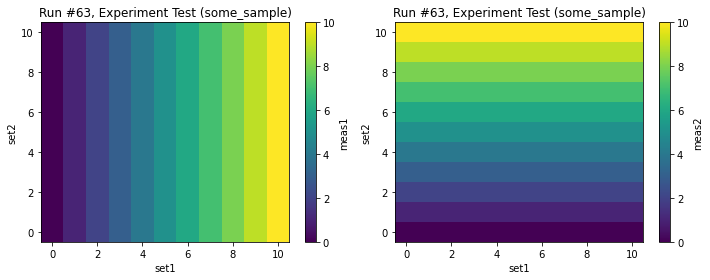

In [29]:
db_path = "complex.db"
qc.initialise_or_create_database_at(db_path)
experiment = qc.load_or_create_experiment("Test")

dataset_definition = {"dataset_1" : {"independent": [set1, set2], "dependent": [meas1, meas2]}}#,
with complex_measurement_context(dataset_definition, experiment) as datasavers:
    for _ in LinSweeper(set1, 0, 10, 11, 0.001):
        sweep1 = LinSweep(set2, 0, 10, 11, 0.001)
        dond_core(datasavers[0], sweep1, meas1, meas2, additional_setpoints=(set1,))
    datasets =[datasaver.dataset for datasaver in datasavers]

fig, ax = plt.subplots(1,2, figsize = (10,4), tight_layout=True)
plot_dataset(datasets[0], axes=ax);

# dond_core v2 : Infer correct datasaver

In [ ]:
def dond_core_v2(datasavers, *params, additional_setpoints = tuple()):
    sweep_instances, params_meas = _parse_dond_arguments(*params)
    sweeper = _Sweeper(sweep_instances, additional_setpoints)
    for set_events in sweeper:
        results: dict[ParameterBase, Any] = {}
        additional_setpoints_data = process_params_meas(additional_setpoints)
        for set_event in set_events:
            if set_event.should_set:
                set_event.parameter(set_event.new_value)
                for act in set_event.actions:
                    act()
                time.sleep(set_event.delay)

            if set_event.get_after_set:
                results[set_event.parameter] = set_event.parameter()
            else:
                results[set_event.parameter] = set_event.new_value

        meas_value_pair =_call_params(tuple(params_meas))
        for meas_param, value in meas_value_pair:
            results[meas_param] = value

        filtered_results_list = [
            (param, value)
            for param, value in results.items()
        ]
        datasaver.add_result(
            *filtered_results_list,
            *additional_setpoints_data,
        )

# Miscellaneous

### Testing DelegateParameter with a ParameterWithSetpoints source

In [ ]:
setpoint_param = Parameter("setpoints", get_cmd = partial(np.linspace, 0, 10, 11), vals = Arrays(shape=(11,)), set_cmd=None)
pws = ParameterWithSetpoints("pws", setpoints=[setpoint_param,], get_cmd= partial(np.linspace, -10, -100, 11), vals= Arrays(shape=(11,)))
delegate_pws = DelegateParameter("delegate", source = pws)
delegate_pws.setpoints

### Tuple Wrap Decorator

In [ ]:
from typing import Type, TypeVar, Union

from typing_extensions import ParamSpec as CallableParamSpec

T = TypeVar('T')
G = TypeVar('G')
P = CallableParamSpec('P')


def tuple_wrap(
    thing: Union[T, Iterable[T]], wrap_type: type[T]
) -> Tuple[T, ...]:
    if isinstance(thing, wrap_type):
        return (thing,)
    elif isinstance(thing, Iterable):
        return tuple(thing)
    else:
        raise Exception


def tuple_wrap_kwargs(*kwargs_to_wrap: str, wrap_type: type):
    def kwarg_wrapper(func: Callable[P, G]) -> Callable[P,G]:
        def func_wrapper(*args: P.args, **kwargs: P.kwargs) -> G:
            to_wrap_kwargs = {key: value for key, value in kwargs.items() if key in kwargs_to_wrap}
            wrapped_kwargs = {key: tuple_wrap(value, wrap_type=wrap_type) for key, value in to_wrap_kwargs.items()}
            kwargs.update(wrapped_kwargs)
            return func(*args, **kwargs)
        return func_wrapper
    return kwarg_wrapper

# Example


@tuple_wrap_kwargs("a", "c",  wrap_type=str)
def decorator_test(**kwargs):
    print(kwargs)


decorator_test(a="foo", b=5, c= ["bar", "bar2"])
# decorator_test(a=(2,5), b=5, c= 7)